<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sampling-100-structures-from-two-100-ps-MD-traj-of-Li3PS4" data-toc-modified-id="Sampling-100-structures-from-two-100-ps-MD-traj-of-Li3PS4-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sampling 100 structures from two 100-ps MD traj of Li3PS4</a></span><ul class="toc-item"><li><span><a href="#load-structures" data-toc-modified-id="load-structures-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>load structures</a></span></li><li><span><a href="#get-structural-features-and-atomic-features" data-toc-modified-id="get-structural-features-and-atomic-features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>get structural features and atomic features</a></span></li><li><span><a href="#plot-structural-and-atomic-feature-space----supercells-vs-unit-cells" data-toc-modified-id="plot-structural-and-atomic-feature-space----supercells-vs-unit-cells-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>plot structural and atomic feature space -- supercells vs unit cells</a></span></li><li><span><a href="#2DIRECT-sampling----an-example" data-toc-modified-id="2DIRECT-sampling----an-example-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>2DIRECT sampling -- an example</a></span><ul class="toc-item"><li><span><a href="#step-1:-Partition-2,002-structures-into-20-groups-according-to-location-in-structural-feature-space" data-toc-modified-id="step-1:-Partition-2,002-structures-into-20-groups-according-to-location-in-structural-feature-space-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>step 1: Partition 2,002 structures into 20 groups according to location in structural feature space</a></span></li><li><span><a href="#Step-2:-DIRECT-sampling-from-each-cluster-according-to-atomic-features-and-structure-size" data-toc-modified-id="Step-2:-DIRECT-sampling-from-each-cluster-according-to-atomic-features-and-structure-size-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Step 2: DIRECT sampling from each cluster according to atomic features and structure size</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from maml.describers import M3GNetSite, M3GNetStructure
from maml.sampling.direct import DIRECTSampler, BirchClustering, SelectKFromClusters
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [2]:
featurizer_atom = M3GNetSite(output_layers=['gc_1'])
featurizer_structure = M3GNetStructure()

# Sampling 100 structures from two 100-ps MD traj of Li3PS4 

1001 MD snapshots in each trajectory, starting from Li3PS4 (unit cell) and Li24P8S32 (supercell)

The required files (10p.traj and M3GNet_features_TiH_274000.pickle) can be downloaded at: https://figshare.com/articles/dataset/20230723_figshare_DIRECT_zip/23734134

## load structures

In [3]:
from pymatgen.core import Structure, Lattice, Element
from pymatgen.io.lammps.outputs import parse_lammps_dumps
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def read_dumped_structures_all(file:str, ff_elements=["Li", "P", "S"]):
    structures = []
    ff_elements = [str(e) for e in sorted(Element(el) for el in ff_elements)]
    total_ss = parse_lammps_dumps(file)
    try:
        for i in total_ss:
            box=i.box
            L=i.box.to_lattice()
            atom_position = i.data
            atom_position = atom_position.sort_values(by="id")
            species = list(atom_position["type"])
            species = [ff_elements[i-1] for i in species]
            coordinate = np.concatenate((np.array(atom_position["x"]).reshape(len(species),1),
                             np.array(atom_position["y"]).reshape(len(species),1),
                             np.array(atom_position["z"]).reshape(len(species),1)),axis=1)
            structure=Structure(L,species,coordinate,coords_are_cartesian=True)
            structures.append(structure)
    except Exception as e:
        print(f"failed to parse {file} with error {e}")
        structures.append(None)
    for i,s in enumerate(structures):
        if s==None:
            structures[i] = structures[i-1]
#     print(f"Collected {len(structures)} structures.")
    return structures

In [4]:
%%time
structures_MD_supercells = read_dumped_structures_all("dump.100ps.mp-2646995_64_Li24P8S32")
structures_MD_unitcells = read_dumped_structures_all("dump.100ps.mp-2646995_8_Li3P1S4")
all_structures = structures_MD_supercells + structures_MD_unitcells

CPU times: user 3.72 s, sys: 1.28 s, total: 5 s
Wall time: 1.26 s


In [5]:
len(structures_MD_supercells), len(structures_MD_unitcells)

(1001, 1001)

In [6]:
set([len(s) for s in structures_MD_supercells]), set([len(s) for s in structures_MD_unitcells])

({64}, {8})

## get structural features and atomic features

In [7]:
%%time
atom_features_supercells = [featurizer_atom.transform_one(s).to_numpy() for s in structures_MD_supercells]
atom_features_unitcells =  [featurizer_atom.transform_one(s).to_numpy() for s in structures_MD_unitcells]
struct_features_supercells = [featurizer_structure.transform_one(s) for s in structures_MD_supercells]
struct_features_unitcells = [featurizer_structure.transform_one(s) for s in structures_MD_unitcells]


CPU times: user 2min 14s, sys: 21.2 s, total: 2min 36s
Wall time: 1min 36s


In [8]:
np.array(atom_features_supercells).shape, np.array(atom_features_unitcells).shape

((1001, 64, 64), (1001, 8, 64))

In [9]:
np.array(struct_features_supercells).shape, np.array(struct_features_unitcells).shape

((1001, 128), (1001, 128))

## plot structural and atomic feature space -- supercells vs unit cells
The reasons behind the interesting, inverse trend of coverage by unit cells and supercells in structural and atomic feature spaces have been discussed in MatPES manuscript.

Text(0.5, 1.0, 'M3GNet structural feature')

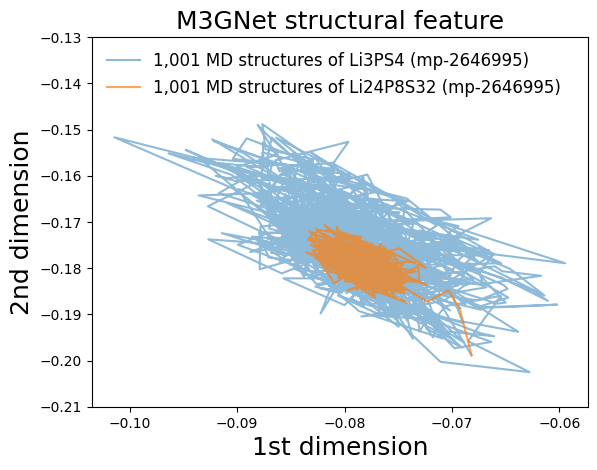

In [10]:
plt.plot(
    np.array(struct_features_unitcells)[:, 0], np.array(struct_features_unitcells)[:, 1], 
    alpha=0.5, label=f"{len(struct_features_unitcells):,} MD structures of Li3PS4 (mp-2646995)"
)
plt.plot(
    np.array(struct_features_supercells)[:, 0], np.array(struct_features_supercells)[:, 1],
    alpha=0.7, label=f"{len(struct_features_unitcells):,} MD structures of Li24P8S32 (mp-2646995)"
)
plt.ylim(-0.21, -0.13)
plt.legend(frameon=False, loc="upper left", fontsize=12)
plt.xlabel("1st dimension", fontsize=18)
plt.ylabel("2nd dimension", fontsize=18)
plt.title("M3GNet structural feature", fontsize=18)

Text(0.5, 1.0, 'M3GNet atomic feature')

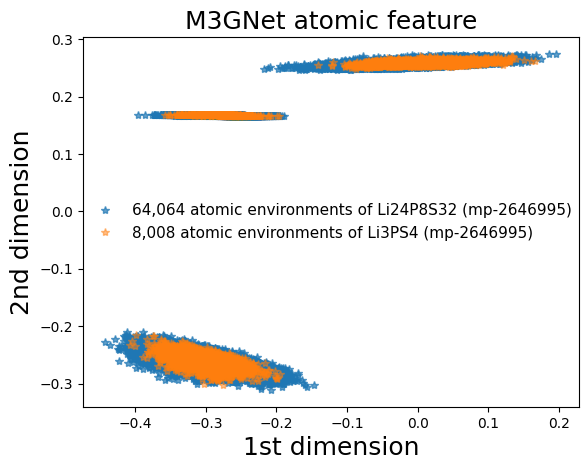

In [11]:
atom_features_unitcells_flatten = np.array([af for afs in atom_features_unitcells for af in afs])
atom_features_supercells_flatten = np.array([af for afs in atom_features_supercells for af in afs])

plt.plot(
    atom_features_supercells_flatten[:, 0], atom_features_supercells_flatten[:, 1], "*",
    alpha=0.7, label=f"{len(atom_features_supercells_flatten):,} atomic environments of Li24P8S32 (mp-2646995)"
)
plt.plot(
    atom_features_unitcells_flatten[:, 0], atom_features_unitcells_flatten[:, 1], "*",
    alpha=0.5, label=f"{len(atom_features_unitcells_flatten):,} atomic environments of Li3PS4 (mp-2646995)"
)

# plt.ylim(-0.21, -0.13)
plt.legend(frameon=False, loc="center", fontsize=11)
plt.xlabel("1st dimension", fontsize=18)
plt.ylabel("2nd dimension", fontsize=18)
plt.title("M3GNet atomic feature", fontsize=18)

## 2DIRECT sampling -- an example
2DIRECT is designed to sample structures with representative atomic environments. It samples structures as small as possible to minimize computational cost, while it picks large cells only when necessary. More details can be found in the manuscript. <font color='red'>Note: the original DIRECT, which takes care of sampling in space of structural features, should work fine if unit cells and supercells are not mixed. </font>

In this particular example, supercells and unit cells are mixed, and we show how 2DIRECT compares with the original DIRECT sampling. We can see that:

1. 2DIRECT better samples atomic feature space than the original DIRECT.
2. 2DIRECT sampled structures have a lower number of sites than the average of all structures, as large supercells are sampled only when necessary.

### step 1: Partition 2,002 structures into 20 groups according to location in structural feature space

In [12]:
%%time
DIRECT_partitioner = DIRECTSampler(
    structure_encoder=None,
    clustering=BirchClustering(n=20, threshold_init=0.05), 
    select_k_from_clusters=None
)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 20 µs


In [13]:
%%time
DIRECT_partition = DIRECT_partitioner.fit_transform(struct_features_supercells+struct_features_unitcells)

INFO:maml.sampling.pca:Selected first 9 PCs, explaining 95.85% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.05 and n=20 gives 20 clusters.


CPU times: user 2.14 s, sys: 2.71 s, total: 4.85 s
Wall time: 665 ms


### Step 2: DIRECT sampling from each cluster according to atomic features and structure size

In [14]:
%%time
sampled_structure_ids = []
for label in set(DIRECT_partition['labels']):
    structure_ids = np.where(DIRECT_partition['labels']==label)[0]
    atom_features = [
        af for i,afs in enumerate(
            atom_features_supercells + atom_features_unitcells
        ) if i in structure_ids for af in afs
    ] 
    nsites = [n for i,s in enumerate(all_structures) for n in [len(s)]*len(s) if i in structure_ids]
    structure_ids_atomf = [i for i,s in enumerate(all_structures) for n in [len(s)]*len(s) if i in structure_ids]
    
    direct_sampler = DIRECTSampler(None,
                                   clustering=BirchClustering(n=40, threshold_init=0.05),  
                                   select_k_from_clusters=SelectKFromClusters(
                                       selection_criteria="smallest", n_sites=nsites
                                   )
                                  )
    DIRECT_sampling = direct_sampler.fit_transform(np.array(atom_features))
    struct_ids = list(set([structure_ids_atomf[i] for i in DIRECT_sampling['selected_indexes']]))
    sampled_structure_ids.extend(struct_ids)
sampled_structure_ids = list(set(sampled_structure_ids))
print(f"Selected in total {len(sampled_structure_ids)} smallest possible structures with 2DIRECT")

INFO:maml.sampling.pca:Selected first 2 PCs, explaining 98.11% variance
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (29) by BIRCH is less than (40). Decrease the threshold.
  warnings.warn(
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.05 and n=40 gives 29 clusters.
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.03625 and n=40 gives 40 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 40 configurations.
INFO:maml.sampling.pca:Selected first 2 PCs, explaining 97.98% variance
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (39) by BIRCH is less than (40). Decrease the threshold.
  warnings.warn(
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.05 and n=40 gives 39 clusters.
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.04875

INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.05 and n=40 gives 40 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 40 configurations.
INFO:maml.sampling.pca:Selected first 2 PCs, explaining 97.58% variance
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (19) by BIRCH is less than (40). Decrease the threshold.
  warnings.warn(
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.05 and n=40 gives 19 clusters.
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (36) by BIRCH is less than (40). Decrease the threshold.
  warnings.warn(
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.02375 and n=40 gives 36 clusters.
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (39) by BIRCH i

Selected in total 392 smallest possible structures with 2DIRECT
CPU times: user 31.1 s, sys: 38.5 s, total: 1min 9s
Wall time: 9.52 s


In [15]:
def plot_feature_coverage(selected_indexes, method="2DIRECT", 
                          all_features=np.array([struct_features_supercells+struct_features_unitcells][0]), 
                          all_features_atoms=atom_features_supercells+atom_features_unitcells):
    fig, ax = plt.subplots(figsize=(6, 5))
    selected_features = all_features[selected_indexes]
    ave_all = round(np.mean([len(s) for s in all_structures]))
    ave_selected = round(np.mean([len(s) for i,s in enumerate(all_structures) if i in selected_indexes]))
    plt.plot(all_features[:, 0], all_features[:, 1], "*", alpha=0.5, 
             label=f"All {len(all_features):,} structures, nsite$_{{ave}}$={ave_all}")
    plt.plot(
        selected_features[:, 0],
        selected_features[:, 1],
        "*",
        alpha=0.5,
        label=f"{method} sampled {len(selected_features):,} structures, nsite$_{{ave}}$={ave_selected}",
    )
    legend = plt.legend(frameon=False, fontsize=12, loc="upper left", bbox_to_anchor=(-0.02, 1.02), reverse=False)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.xlabel("1st dimension", fontsize=18)
    plt.ylabel("2nd dimension", fontsize=18)
    plt.title("M3GNet structural feature", fontsize=18)
    plt.ylim(-0.21, -0.13)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(6, 5))
    all_features_atoms_flatten = np.array([af for afs in all_features_atoms for af in afs])
    atom_features_atom_selected_flatten = np.array([
        af for i,afs in enumerate(all_features_atoms) if i in selected_indexes for af in afs])
    plt.plot(
    all_features_atoms_flatten[:, 0], all_features_atoms_flatten[:, 1], "*",
    alpha=0.5, label=f"All {len(all_features_atoms_flatten):,} atomic environments"
    )
    plt.plot(
    atom_features_atom_selected_flatten[:, 0], atom_features_atom_selected_flatten[:, 1], "*",
    alpha=0.5, label=f"{method} selected {len(atom_features_atom_selected_flatten):,}"
)
    # plt.ylim(-0.21, -0.13)
    
    legend = plt.legend(frameon=False, fontsize=12, loc="center", reverse=False)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.xlabel("1st dimension", fontsize=18)
    plt.ylabel("2nd dimension", fontsize=18)
    plt.title("M3GNet atomic feature", fontsize=18)

/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_96690/2361647495.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


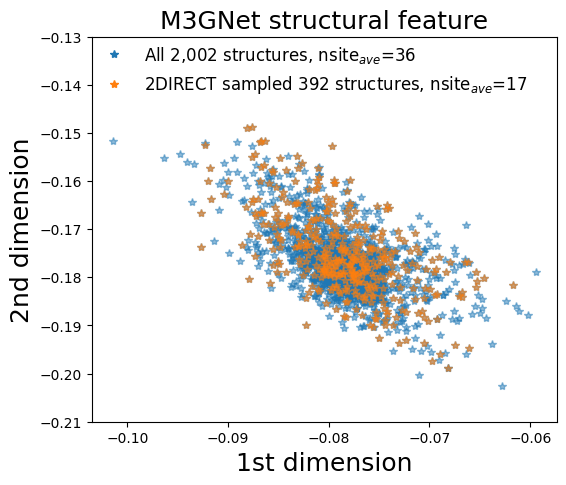

/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_96690/2361647495.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


CPU times: user 579 ms, sys: 895 ms, total: 1.47 s
Wall time: 227 ms


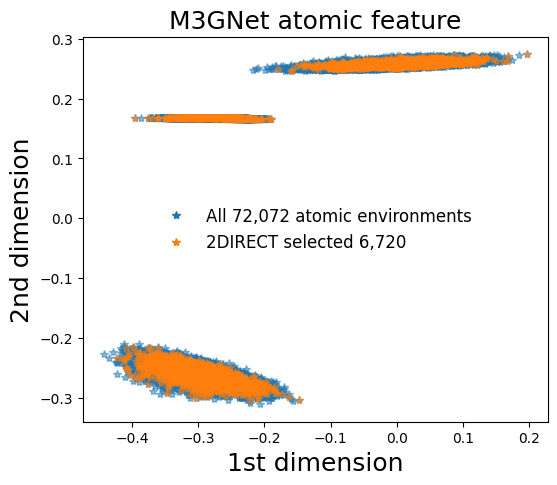

In [16]:
%%time
plot_feature_coverage(sampled_structure_ids)

In [17]:
%%time
direct_original = DIRECTSampler(None, clustering=BirchClustering(n=392, threshold_init=0.05))
DIRECT_original = direct_original.fit_transform(struct_features_supercells+struct_features_unitcells)
sampled_structure_ids_original = DIRECT_original['selected_indexes']

INFO:maml.sampling.pca:Selected first 9 PCs, explaining 95.85% variance
INFO:maml.sampling.clustering:BirchClustering with threshold_init=0.05 and n=392 gives 392 clusters.
INFO:maml.sampling.stratified_sampling:Finally selected 392 configurations.


CPU times: user 1.63 s, sys: 1.71 s, total: 3.33 s
Wall time: 431 ms


/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_96690/2361647495.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


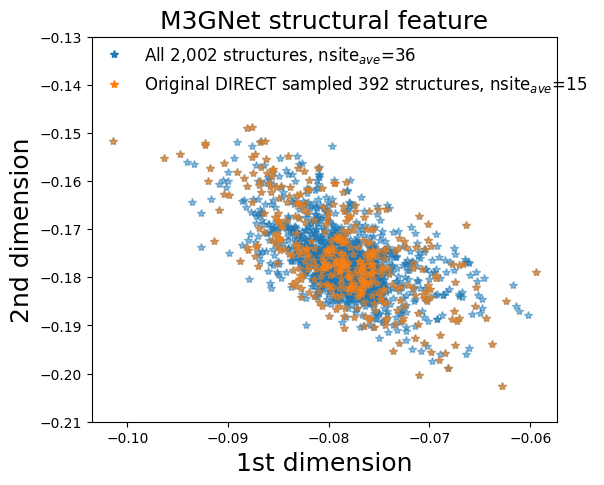

/var/folders/rr/d33n0r7d06zc3bfdcz58s0w00000gn/T/ipykernel_96690/2361647495.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


CPU times: user 657 ms, sys: 330 ms, total: 987 ms
Wall time: 136 ms


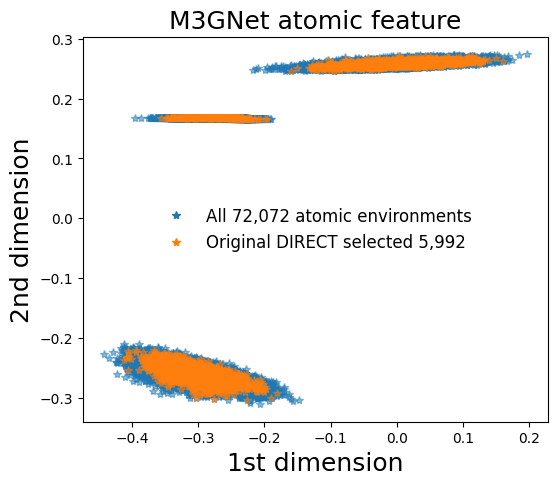

In [18]:
%%time
plot_feature_coverage(sampled_structure_ids_original, method="Original DIRECT")